## Интерпретация моделей и калибровка вероятностей

Будем тренироваться на примере задачи классификации оттоковых клиентов

In [1]:
!pip install eli5 -q
!pip install lime -q
!pip install shap -q
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import eli5, lime, shap

from catboost import CatBoostClassifier

Загрузим данные

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/churn_clients.csv")

data.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,KS,128,415,No,Yes,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,False


Обработайте признаки:

* удалите категориальные признаки с больше, чем двумя различными значениями (обратите внимание, что `areacode` - также категориальный признак)

* бинарные признаки перведите в числа: True/Yes -> 1, False/No -> 0

In [11]:
data.describe(include=[object])

,state,internationalplan,voicemailplan
count,3333,3333,3333
unique,51,2,2
top,WV,No,No
freq,106,3010,2411


In [12]:
data.areacode.value_counts()

415    1655
510     840
408     838
Name: areacode, dtype: int64

In [13]:
data.drop(columns=['areacode', 'state'], inplace=True)

In [16]:
data['internationalplan'] = data['internationalplan'].map({'Yes': 1, 'No': 0})

In [17]:
data['voicemailplan'] = data['voicemailplan'].map({'Yes': 1, 'No': 0})

## Вопрос

Сколько колонок осталось в таблице data?

In [19]:
data.shape[1]

18

In [20]:
X = data.drop('churn', axis=1)
y = data['churn']

Разбейте данные на тренировочную и тестовую части. Размер тестовой части - 25%, `random_state=42`.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
y_train = y_train.map({True: 1, False: 0})
y_test = y_test.map({True: 1, False: 0})

## Вопрос

Сколько строк в тренировочных данных?

In [23]:
X_train.shape[0]

2499

Обучите CatBoostClassifier с гиперпараметрами по умолчанию и `random_state=42` на тренировочных данных, сделайте прогноз на тестовых данных и вычислите значение ROC-AUC.

In [27]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(random_state=42, verbose=0).fit(X_train, y_train)


In [31]:
y_pred = model.predict_proba(X_test)


array([0.06503245, 0.01749443, 0.95460748, 0.03493447, 0.01325616,
       0.04355952, 0.01480371, 0.02006743, 0.02101558, 0.03159326,
       0.01091416, 0.0207751 , 0.00839958, 0.9374345 , 0.01859243,
       0.07372615, 0.01320719, 0.73745208, 0.03992098, 0.01101536,
       0.00941954, 0.0153425 , 0.0252024 , 0.25963228, 0.01163206,
       0.01752312, 0.01073656, 0.33298032, 0.01506271, 0.05855004,
       0.01447514, 0.07990123, 0.0049934 , 0.01078957, 0.05497166,
       0.03683622, 0.03039932, 0.00853249, 0.95960372, 0.26856965,
       0.01815882, 0.04582863, 0.03753589, 0.17000098, 0.05486351,
       0.02830808, 0.48255995, 0.35184401, 0.00872326, 0.03292207,
       0.04493307, 0.65965801, 0.02199355, 0.01069287, 0.04082546,
       0.03933183, 0.04113409, 0.01859828, 0.02479377, 0.02093705,
       0.02534058, 0.01438557, 0.01489355, 0.02701987, 0.04704639,
       0.10236476, 0.02026834, 0.05204858, 0.93927933, 0.00385571,
       0.51918874, 0.03934067, 0.02222362, 0.97116776, 0.00851

## Вопрос

Чему равно значение ROC-AUC на тестовых данных? Ответ округлите до сотых.

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred[:,1])

0.9355035260930887

Выведите на экран гистограмму важности признаков (стандартную, посчитанную на основе Information Gain)

In [33]:
model.feature_importances_

array([ 2.71494617, 11.31569438,  3.90773663,  4.180778  , 11.09551568,
        3.11445353, 11.02497807,  6.26288467,  2.60681585,  5.90839476,
        3.79060354,  3.03716209,  3.39136537,  4.0320352 ,  7.07262639,
        4.2153758 , 12.32863388])

## Вопрос

Какой признак наиболее важен с точки зрения этого подхода?

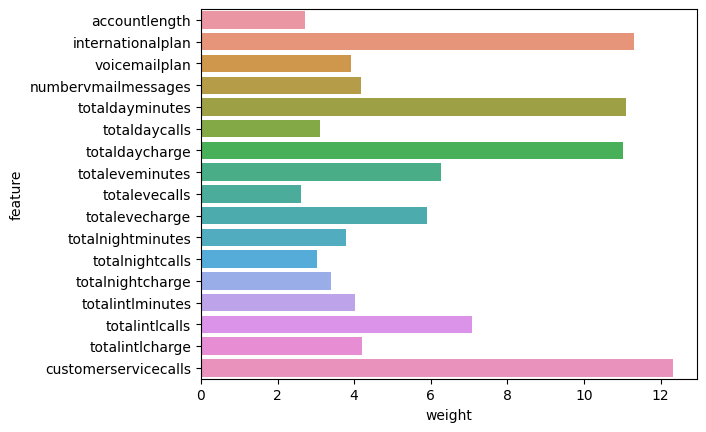

In [34]:
model_imps = pd.DataFrame({"feature": X.columns,
                        "weight": model.feature_importances_})
sns.barplot(data=model_imps, y="feature", x="weight")
plt.show()

Постройте гистограмму permutation importance по тренировочным данным

In [35]:
perm = eli5.sklearn.PermutationImportance(model, random_state=42).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0599 ± 0.0047,customerservicecalls
0.0545 ± 0.0053,totaldaycharge
0.0519 ± 0.0045,internationalplan
0.0502 ± 0.0065,totaldayminutes
0.0241 ± 0.0031,totalintlcalls
0.0211 ± 0.0012,totaleveminutes
0.0189 ± 0.0014,totalevecharge
0.0142 ± 0.0026,numbervmailmessages
0.0138 ± 0.0032,voicemailplan
0.0130 ± 0.0015,totalintlcharge


## Вопрос

Сколько признаков выделяет метод как наиболее важные? (темно-зеленый цвет на визуализации)

In [ ]:
4

Постройте гистограмму shap values по тестовым данным

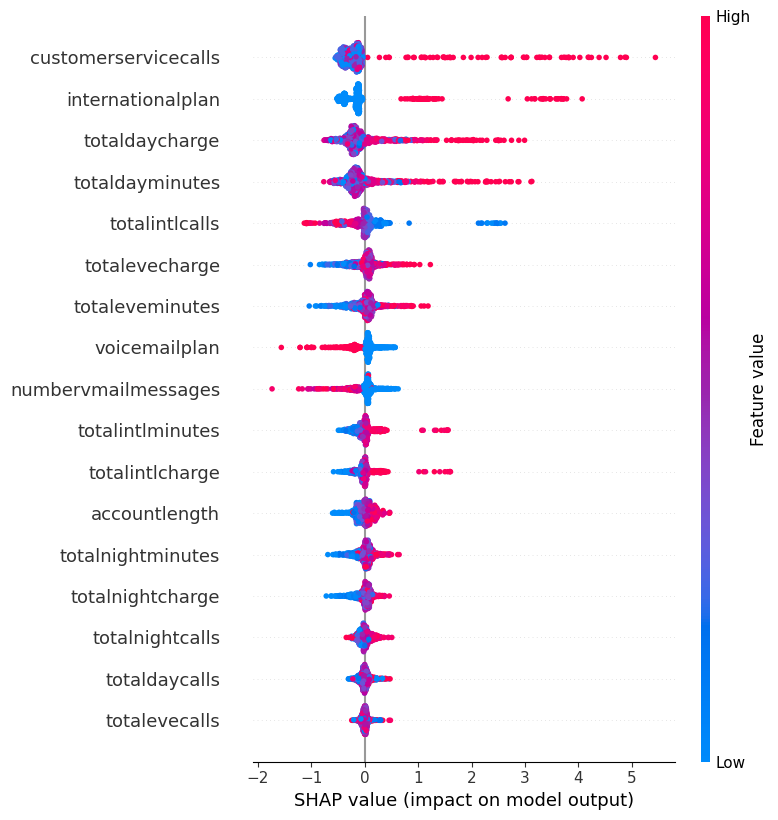

In [36]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

## Вопрос

Какой признак наименее важен с точки зрения подхода SHAP?

Проинтерпретируем теперь индивидуальные прогнозы моделей

Проинтерпретируйте прогноз на тестовом объекте с индексом 5 методами:

* SHAP
* LIME

In [37]:
shap.initjs()

print('Correct answer:', y_test.iloc[5])
shap.force_plot(explainer.expected_value, shap_values[5,:], X_test.iloc[5,:])

Correct answer: 0


In [38]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=X_test.columns.values.tolist(), mode='regression')
explanation = explainer.explain_instance(X_test.values[5], model.predict, num_features=5)

explanation.show_in_notebook(show_table=True)

## Вопрос

Какой признак дает наибольший вклад в прогноз с точки зрения SHAP?

In [ ]:
# your code here

## Вопрос

Какой признак дает наибольший вклад в прогноз с точки зрения метода LIME?

## Калибровка вероятностей

Сделайте калибровку вероятностей с помощью методов 'sigmoid' и 'isotonic' при помощи CalibratedClassifierCV с `cv=2`.

Нарисуйте на одном графике исходную калибровочную кривую для CatBoost и две кривые после калибровки.

In [40]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

from sklearn.metrics import brier_score_loss

In [45]:
CB_isotonic = CalibratedClassifierCV(model, cv=2, method="isotonic")
CB_sigmoid = CalibratedClassifierCV(model, cv=2, method="sigmoid")

clf_list = [
    (model, "CatBoost"),
    (CB_isotonic, "CatBoost + Isotonic"),
    (CB_sigmoid, "CatBoost + Sigmoid"),
]

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


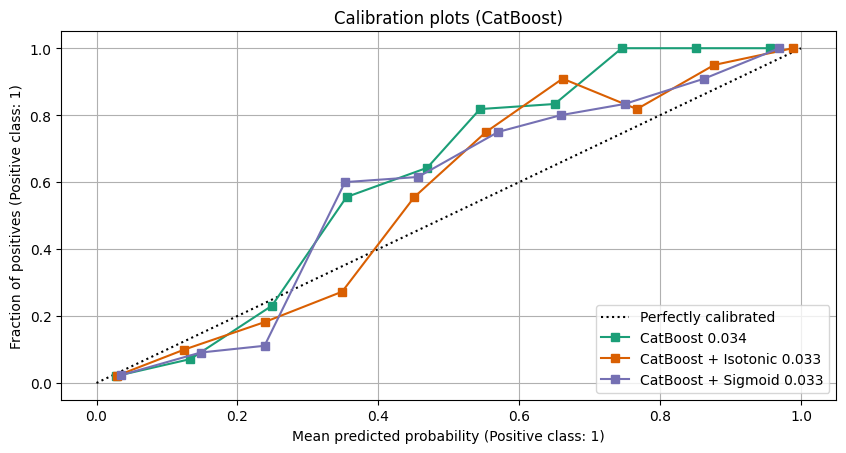

In [46]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    bs = np.round(brier_score_loss(y_test, clf.predict_proba(X_test)[:,1]), 3)

    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name + " " + str(bs),
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (CatBoost)");

Вычислим `brier_score` до калибровки

In [ ]:
from sklearn.metrics import brier_score_loss

brier_score_loss(y_test, probs)

0.0335565178559375

## Вопрос

Вычислите `brier_score` после обеих калибровок.

В ответ запишите наименьшее из двух полученных значений, округленное до десятитысячных.

In [48]:
brier_score_loss(y_test, CB_sigmoid.predict_proba(X_test)[:,1])

0.03318200504500793

In [49]:
brier_score_loss(y_test, CB_isotonic.predict_proba(X_test)[:,1])

0.03339137327565761